In [1]:
import numpy as np
import pandas as pd
import gdreg
import time
import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH='/n/groups/price/martin/WES_analysis/'
OUT_PATH = '/n/groups/price/martin/WES_analysis/toy_1K'

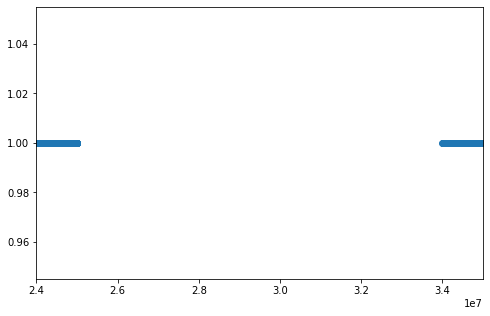

24999740
34005069


In [13]:
# # Check MHC 
# temp_df = pd.read_csv('/n/groups/price/martin/WES_analysis/toy_1K/weights_hm3_no_hla/weights.6.l2.ldscore.gz',
#                       sep='\t')
# plt.figure(figsize=[8,5])
# plt.scatter(temp_df['BP'], [1]*temp_df.shape[0])
# plt.xlim([2.4e7,3.5e7])
# plt.show()

# print(temp_df['BP'][temp_df['BP']<3e7].max())
# print(temp_df['BP'][temp_df['BP']>3e7].min())

### Sample list (1K) and SNP list (10K) from WES_50K
- Plink file: /n/groups/price/UKBiobank/WES_50K/chr*_v1.SPB.hg19.bed
- Plink .frq file: /n/groups/price/UKBiobank/WES_50K/freq/chr*_v1.SPB.hg19.frq
- 340K unrelated inviduals: /n/groups/price/UKBiobank/sampleQC/samples_337K.txt
- Withdrawn samples: /n/groups/price/UKBiobank/download_500K/w14048_CURRENT.FID_IID.txt

In [3]:
# Get 1K sample
df_fam = pd.read_csv('/n/groups/price/UKBiobank/WES_50K/chr1_v1.SPB.hg19.fam', sep=' ', header=None)
df_fam.columns = ['FID', 'IID', 'FATHER', 'MOTHER', 'SEX', 'PHEN']
df_fam.index = ['%s_%s'%(x,y) for x,y in zip(df_fam['FID'], df_fam['IID'])]
print('df_fam: %d'%len(df_fam.index))

df_unrelated = pd.read_csv('/n/groups/price/UKBiobank/sampleQC/samples_337K.txt', sep=' ', header=None)
df_unrelated.columns = ['FID', 'IID']
df_unrelated.index = ['%s_%s'%(x,y) for x,y in zip(df_unrelated['FID'], df_unrelated['IID'])]
print('df_unrelated: %d'%len(df_unrelated.index))

df_remove = pd.read_csv(
    '/n/groups/price/UKBiobank/download_500K/w14048_CURRENT.FID_IID.txt', sep=' ', header=None
)
df_remove.columns = ['FID', 'IID']
df_remove.index = ['%s_%s'%(x,y) for x,y in zip(df_remove['FID'], df_remove['IID'])]
print('df_remove: %d'%len(df_remove.index))

# Subsample ID_list
legit_id_list = sorted(set(df_fam.index) & set(df_unrelated.index) - set(df_remove.index))
print('legit_id_list: %d'%len(legit_id_list))

np.random.seed(0)
id_1K_list = np.random.choice(legit_id_list, size=1000, replace=False)
id_1K_list = sorted(set(id_1K_list))
print('id_10K_list: %d'%len(id_1K_list))

df_id_1K = df_fam.loc[id_1K_list, ['FID', 'IID']]
df_id_1K.to_csv(OUT_PATH+'/ID1K_unrelated.txt', sep=' ', header=False, index=False)

df_fam: 49960
df_unrelated: 337545
df_remove: 242
legit_id_list: 34415
id_10K_list: 1000


In [13]:
df_freq

,CHR,SNP,A1,A2,MAF,NCHROBS
50,6,6:292658:T:C,C,T,0.06134,99910
134,6,6:311938:C:T,T,C,0.12420,99920
157,6,6:312023:C:T,T,C,0.15690,99554
160,6,6:312029:D:4,T,TAATG,0.42480,95302
194,6,6:335251:T:C,C,T,0.45900,99008
...,...,...,...,...,...,...
489573,6,6:170582768:C:A,C,A,0.49700,99920
489599,6,6:170583012:T:C,T,C,0.49970,99920
489691,6,6:170583760:A:G,G,A,0.49910,99848
489698,6,6:170583831:I:4,TACTC,T,0.42630,79912


In [15]:
# # Get 20K SNPs from first 10 CHRs (2K each, with some redundancy)
# BIM_FILE = '/n/groups/price/UKBiobank/WES_50K/chr@_v1.SPB.hg19.bim'
# FRQ_FILE = '/n/groups/price/UKBiobank/WES_50K/freq/chr@_v1.SPB.hg19.frq'
# snp_list = []
# for CHR in range(1, 11):
#     df_freq = pd.read_csv(FRQ_FILE.replace('@', '%d'%CHR), delim_whitespace=True)
#     df_freq = df_freq.loc[df_freq['MAF']>0.05]
#     if CHR == 6:
#         df_bim = pd.read_csv(BIM_FILE.replace('@', '%d'%CHR), delim_whitespace=True, header=None)
#         dic_bp = {x:y for x,y in zip(df_bim[1], df_bim[3])}
#         df_freq['BP'] = [dic_bp[x] for x in df_freq['SNP']]
#         df_freq = df_freq.loc[(df_freq['BP']<2.5e7) | (df_freq['BP']>3.4e7)]
#     snp_list.extend(df_freq['SNP'].values[:1500])
    
# with open(OUT_PATH+'/SNP15K_CHR1t10_MAFg5_noMHC.txt', 'w') as f:
#     for snp in snp_list:
#         f.write('%s\n'%snp)

### Call get_toydata_genotype.sh to get .pgen files

In [16]:
# Check if the files are good
PGEN_FILE = OUT_PATH + '/chr@_v1.SPB.hg19.toy_1K'
dic_data = {}
for CHR in range(1,11):
    dic_data[CHR] = gdreg.util.read_pgen(PGEN_FILE.replace('@', '%s'%CHR))
    print(CHR, 'n_snp=%d'%dic_data[CHR]['pvar'].shape[0])
    if CHR==1:
        display(dic_data[CHR]['pvar'])
        display(dic_data[CHR]['psam'])
        display(dic_data[CHR]['afreq'])

1 n_snp=1400


,CHR,BP,SNP,REF,ALT
0,1,69761,1:69761:A:T,A,T
1,1,866511,1:931131:I:4.01,CCCCT,C
2,1,871334,1:935954:G:T,T,G
3,1,874816,1:939436:I:1,C,CT
4,1,876499,1:941119:A:G,G,A
...,...,...,...,...,...
1395,1,12939440,1:12879619:C:G,C,G
1396,1,12939467,1:12879646:C:T,C,T
1397,1,12939476,1:12879655:G:C,G,C
1398,1,12939546,1:12879725:I:1,C,CG


,FID,IID,SEX
0,4663783,4663783,2
1,3967789,3967789,1
2,1292546,1292546,2
3,1605909,1605909,1
4,1637792,1637792,2
...,...,...,...
995,1937047,1937047,2
996,1664399,1664399,1
997,3710395,3710395,1
998,4555321,4555321,1


,CHR,SNP,REF,ALT,MAF,OBS_CT
0,1,1:69761:A:T,A,T,0.087906,1968
1,1,1:931131:I:4.01,CCCCT,C,0.253638,1924
2,1,1:935954:G:T,T,G,0.275000,2000
3,1,1:939436:I:1,C,CT,0.056000,2000
4,1,1:941119:A:G,G,A,0.047547,1998
...,...,...,...,...,...,...
1395,1,1:12879619:C:G,C,G,0.123000,2000
1396,1,1:12879646:C:T,C,T,0.123500,2000
1397,1,1:12879655:G:C,G,C,0.117000,2000
1398,1,1:12879725:I:1,C,CG,0.114500,2000


2 n_snp=1322
3 n_snp=1326
4 n_snp=1341
5 n_snp=1311
6 n_snp=1319
7 n_snp=1375
8 n_snp=1320
9 n_snp=1307
10 n_snp=1280


### Create annotations

In [18]:
# # Create .annot.gz file
# df_annot = None
# for CHR in dic_data:
#     if df_annot is None:
#         df_annot = dic_data[CHR]['pvar']
#     else:
#         df_annot = pd.concat([df_annot, dic_data[CHR]['pvar']], axis=0)
        
# df_annot = df_annot[['CHR', 'SNP', 'BP']]
# df_annot['CM'] = 0
# df_annot['AN:ALL'] = 1
# df_annot['AN:CHR1'] = (df_annot['CHR']==1)*1
# df_annot['AN:ODD'] = ((df_annot['CHR'] % 2) == 1) * 1
# gdreg.util.write_annot(df_annot, OUT_PATH+'/toy.annot.gz')

In [19]:
# # Create .pannot.gz file
# df_annot = None
# for CHR in dic_data:
#     if df_annot is None:
#         df_annot = dic_data[CHR]['pvar']
#     else:
#         df_annot = pd.concat([df_annot, dic_data[CHR]['pvar']], axis=0)
        
# df_annot = df_annot[['CHR', 'SNP', 'BP']]
# df_annot['CM'] = 0
# df_annot['pAN:gene'] = 'non-pAN'
# # 5 genes for each CHR, each with 50 SNPs
# for CHR in dic_data:
#     for i in range(5):
#         snp_list = dic_data[CHR]['pvar']['SNP'][i*100:i*100+50]
#         df_annot.loc[df_annot['SNP'].isin(snp_list), 'pAN:gene'] = 'GENE_%d_%d'%(CHR,i)
# gdreg.util.write_annot(df_annot, OUT_PATH+'/toy.pannot.gz')

In [20]:
# # Create .pannot_hr.gz file
# df_annot = None
# for CHR in dic_data:
#     if df_annot is None:
#         df_annot = dic_data[CHR]['pvar']
#     else:
#         df_annot = pd.concat([df_annot, dic_data[CHR]['pvar']], axis=0)
        
# df_annot = df_annot[['CHR', 'SNP', 'BP']]
# df_annot['CM'] = 0

# # SNPs within 10-kb 
# iSNP_list = []
# jSNP_list = []
# v_SNP = df_annot['SNP'].values
# v_CHR = df_annot['CHR'].values
# v_BP = df_annot['BP'].values

# for i in range(v_SNP.shape[0]):
#     for j in range(i+1, v_SNP.shape[0]):
#         if ((v_BP[j] - v_BP[i])<1e4) & (v_CHR[i] == v_CHR[j]):
#             iSNP_list.append(i)
#             jSNP_list.append(j)
#         else:
#             break
        
# df_pannot = pd.DataFrame(data={
#     'CHR' : df_annot['CHR'].values[iSNP_list],
#     'SNP' : df_annot['SNP'].values[iSNP_list],
#     'BP' : df_annot['BP'].values[iSNP_list],
#     'CM' : df_annot['CM'].values[iSNP_list],
#     'pCHR' : df_annot['CHR'].values[jSNP_list],
#     'pSNP' : df_annot['SNP'].values[jSNP_list],
#     'pBP' : df_annot['BP'].values[jSNP_list],
#     'pCM' : df_annot['CM'].values[jSNP_list],
#     'pAN:proxy' : 1,
# })
            
# gdreg.util.write_annot(df_pannot, OUT_PATH+'/toy.pannot_hr.gz')

### Check if the .annot files are good

In [21]:
# Read .annot files
dic_annot = {}
dic_annot['annot'] = gdreg.util.read_annot(OUT_PATH+'/toy.annot.gz')
display(dic_annot['annot'])
dic_annot['pannot'] = gdreg.util.read_annot(OUT_PATH+'/toy.pannot.gz')
display(dic_annot['pannot'])
dic_annot['pannot_hr'] = gdreg.util.read_annot(OUT_PATH+'/toy.pannot_hr.gz')
display(dic_annot['pannot_hr'])

,CHR,SNP,BP,CM,AN:ALL,AN:CHR1,AN:ODD
0,1,1:69761:A:T,69761,0,1,1,1
1,1,1:931131:I:4.01,866511,0,1,1,1
2,1,1:935954:G:T,871334,0,1,1,1
3,1,1:939436:I:1,874816,0,1,1,1
4,1,1:941119:A:G,876499,0,1,1,1
...,...,...,...,...,...,...,...
13296,10,10:32922299:T:G,33211227,0,1,0,0
13297,10,10:32925874:A:G,33214802,0,1,0,0
13298,10,10:32928182:G:A,33217110,0,1,0,0
13299,10,10:32930080:T:G,33219008,0,1,0,0


,CHR,SNP,BP,pAN:gene
0,1,1:69761:A:T,69761,GENE_1_0
1,1,1:931131:I:4.01,866511,GENE_1_0
2,1,1:935954:G:T,871334,GENE_1_0
3,1,1:939436:I:1,874816,GENE_1_0
4,1,1:941119:A:G,876499,GENE_1_0
...,...,...,...,...
13296,10,10:32922299:T:G,33211227,non-pAN
13297,10,10:32925874:A:G,33214802,non-pAN
13298,10,10:32928182:G:A,33217110,non-pAN
13299,10,10:32930080:T:G,33219008,non-pAN


,CHR,SNP,BP,pCHR,pSNP,pBP,pAN:proxy
0,1,1:931131:I:4.01,866511,1,1:935954:G:T,871334,1
1,1,1:931131:I:4.01,866511,1,1:939436:I:1,874816,1
2,1,1:931131:I:4.01,866511,1,1:941119:A:G,876499,1
3,1,1:935954:G:T,871334,1,1:939436:I:1,874816,1
4,1,1:935954:G:T,871334,1,1:941119:A:G,876499,1
...,...,...,...,...,...,...,...
43778,10,10:32922299:T:G,33211227,10,10:32928182:G:A,33217110,1
43779,10,10:32922299:T:G,33211227,10,10:32930080:T:G,33219008,1
43780,10,10:32925874:A:G,33214802,10,10:32928182:G:A,33217110,1
43781,10,10:32925874:A:G,33214802,10,10:32930080:T:G,33219008,1


### Simulate .snpeff and .phen values

In [22]:
# Sanity_nd

df_afreq = None
for CHR in dic_data:
    if df_afreq is None:
        df_afreq = dic_data[CHR]['afreq']
    else:
        df_afreq = pd.concat([df_afreq, dic_data[CHR]['afreq']], axis=0)

dic_coef = {
    'AN:ALL' : 1,
    'AN:CHR1' : 1,
    'AN:ODD' : 0.5,
}

df_annot = dic_annot['annot'].copy()
df_annot['MAF'] = df_afreq['MAF'].values

AN_list = ['AN:ALL', 'AN:CHR1', 'AN:ODD']
pAN_list = ['pAN:gene', 'pAN:proxy']

n_rep = 10 
dic_summary = {}

for i in range(n_rep):
    print(i)
    df_effect = gdreg.simulate.simulate_snp_effect(
        df_annot, 
        dic_coef, 
        pannot_list = [dic_annot['pannot']], 
        pannot_hr_list = [dic_annot['pannot_hr']],
        p_causal = 1,
        alpha=-1,
        verbose=False,
        random_seed=i,
    )

    dic_summary[i] = gdreg.simulate.summarize_snp_effect(
        df_effect,
        df_annot, 
        pannot_list = [dic_annot['pannot']],
        pannot_hr_list = [dic_annot['pannot_hr']],
        verbose=False
    )
    
    df_effect.to_csv(OUT_PATH+'/sanity_nd_rep%d.eff.gz'%i, sep='\t', index=False)
    dic_summary[i].to_csv(OUT_PATH+'/sanity_nd_rep%d.eff_sum'%i, sep='\t', index=False)
    
# Summary 
temp_dic = dic_summary.copy()
for AN in AN_list:
    true_val = dic_coef[AN] if AN in dic_coef else 0
    v_tau = [temp_dic[x].loc[AN, 'tau'] for x in range(n_rep)]
    tau_mean, tau_sd = np.mean(v_tau), np.std(v_tau)
    v_h2_ps = [temp_dic[x].loc[AN, 'h2_ps'] for x in range(n_rep)]
    h2_ps_mean, h2_ps_sd = np.mean(v_h2_ps), np.std(v_h2_ps)
    print('{:^30s}|{:^30s}|{:^30s}'.format(
            '%s (true=%0.2g)'%(AN, true_val), 
            'tau=%0.2g (SD=%0.2g)' % (tau_mean, tau_sd),
            'h2_ps=%0.2g (SD=%0.2g)' % (h2_ps_mean, h2_ps_sd),
        ))
    
for AN in AN_list:
    for pAN in pAN_list:
        true_val = dic_coef['%s|%s'%(pAN,AN)] if '%s|%s'%(pAN,AN) in dic_coef else 0
        v_rho = [temp_dic[x].loc[AN, 'rho|%s'%pAN] for x in range(n_rep)]
        rho_mean, rho_sd = np.mean(v_rho), np.std(v_rho)
        v_r2_ps = [temp_dic[x].loc[AN, 'r2_ps|%s'%pAN] for x in range(n_rep)]
        r2_ps_mean, r2_ps_sd = np.mean(v_rho), np.std(v_rho)
        print('{:^30s}|{:^30s}|{:^30s}'.format(
            '%s|%s (true=%0.2g)'%(pAN,AN,true_val), 
            'rho=%0.2g (SD=%0.2g)' % (rho_mean, rho_sd),
            'r2_ps=%0.2g (SD=%0.2g)' % (r2_ps_mean, r2_ps_sd),
        ))

0
1
2
3
4
5
6
7
8
9
       AN:ALL (true=1)        |   tau=2.7e-05 (SD=1.1e-06)   |  h2_ps=3.7e-05 (SD=1.5e-06)  
       AN:CHR1 (true=1)       |    tau=2.7e-05 (SD=1e-06)    |  h2_ps=6.8e-05 (SD=2.6e-06)  
      AN:ODD (true=0.5)       |   tau=1.4e-05 (SD=5.7e-07)   |  h2_ps=4.6e-05 (SD=1.9e-06)  
   pAN:gene|AN:ALL (true=0)   |    rho=0.0018 (SD=0.018)     |   r2_ps=0.0018 (SD=0.018)    
  pAN:proxy|AN:ALL (true=0)   |    rho=-0.0046 (SD=0.01)     |   r2_ps=-0.0046 (SD=0.01)    
  pAN:gene|AN:CHR1 (true=0)   |   rho=-0.00036 (SD=0.0022)   |  r2_ps=-0.00036 (SD=0.0022)  
  pAN:proxy|AN:CHR1 (true=0)  |    rho=0.0043 (SD=0.012)     |   r2_ps=0.0043 (SD=0.012)    
   pAN:gene|AN:ODD (true=0)   |   rho=2.1e-05 (SD=0.00092)   |  r2_ps=2.1e-05 (SD=0.00092)  
  pAN:proxy|AN:ODD (true=0)   |   rho=-0.00069 (SD=0.0066)   |  r2_ps=-0.00069 (SD=0.0066)  


In [23]:
df_afreq = None
for CHR in dic_data:
    if df_afreq is None:
        df_afreq = dic_data[CHR]['afreq']
    else:
        df_afreq = pd.concat([df_afreq, dic_data[CHR]['afreq']], axis=0)

dic_coef = {
    'AN:ALL' : 1,
    'AN:CHR1' : 1,
    'AN:ODD' : 0.5,
    'pAN:gene|AN:CHR1' : 0.8,
    'pAN:proxy|AN:CHR1' : -0.2,
}

df_annot = dic_annot['annot'].copy()
df_annot['MAF'] = df_afreq['MAF'].values

AN_list = ['AN:ALL', 'AN:CHR1', 'AN:ODD']
pAN_list = ['pAN:gene', 'pAN:proxy']

In [24]:
# Sanity
n_rep = 10 
dic_summary = {}

for i in range(n_rep):
    print(i)
    df_effect = gdreg.simulate.simulate_snp_effect(
        df_annot, 
        dic_coef, 
        pannot_list = [dic_annot['pannot']], 
        pannot_hr_list = [dic_annot['pannot_hr']],
        p_causal = 1,
        alpha=-1,
        verbose=False,
        random_seed=i,
    )

    dic_summary[i] = gdreg.simulate.summarize_snp_effect(
        df_effect,
        df_annot, 
        pannot_list = [dic_annot['pannot']],
        pannot_hr_list = [dic_annot['pannot_hr']],
        verbose=False
    )
    
    df_effect.to_csv(OUT_PATH+'/sanity_rep%d.eff.gz'%i, sep='\t', index=False)
    dic_summary[i].to_csv(OUT_PATH+'/sanity_rep%d.eff_sum'%i, sep='\t', index=False)
    
# Summary 
temp_dic = dic_summary.copy()
for AN in AN_list:
    true_val = dic_coef[AN] if AN in dic_coef else 0
    v_tau = [temp_dic[x].loc[AN, 'tau'] for x in range(n_rep)]
    tau_mean, tau_sd = np.mean(v_tau), np.std(v_tau)
    v_h2_ps = [temp_dic[x].loc[AN, 'h2_ps'] for x in range(n_rep)]
    h2_ps_mean, h2_ps_sd = np.mean(v_h2_ps), np.std(v_h2_ps)
    print('{:^30s}|{:^30s}|{:^30s}'.format(
            '%s (true=%0.2g)'%(AN, true_val), 
            'tau=%0.2g (SD=%0.2g)' % (tau_mean, tau_sd),
            'h2_ps=%0.2g (SD=%0.2g)' % (h2_ps_mean, h2_ps_sd),
        ))
    
for AN in AN_list:
    for pAN in pAN_list:
        true_val = dic_coef['%s|%s'%(pAN,AN)] if '%s|%s'%(pAN,AN) in dic_coef else 0
        v_rho = [temp_dic[x].loc[AN, 'rho|%s'%pAN] for x in range(n_rep)]
        rho_mean, rho_sd = np.mean(v_rho), np.std(v_rho)
        v_r2_ps = [temp_dic[x].loc[AN, 'r2_ps|%s'%pAN] for x in range(n_rep)]
        r2_ps_mean, r2_ps_sd = np.mean(v_rho), np.std(v_rho)
        print('{:^30s}|{:^30s}|{:^30s}'.format(
            '%s|%s (true=%0.2g)'%(pAN,AN,true_val), 
            'rho=%0.2g (SD=%0.2g)' % (rho_mean, rho_sd),
            'r2_ps=%0.2g (SD=%0.2g)' % (r2_ps_mean, r2_ps_sd),
        ))

0
1
2
3
4
5
6
7
8
9
       AN:ALL (true=1)        |   tau=2.7e-05 (SD=1.1e-06)   |  h2_ps=3.8e-05 (SD=1.9e-06)  
       AN:CHR1 (true=1)       |   tau=3.5e-05 (SD=7.1e-06)   |  h2_ps=7.5e-05 (SD=8.3e-06)  
      AN:ODD (true=0.5)       |   tau=1.4e-05 (SD=5.7e-07)   |  h2_ps=4.8e-05 (SD=2.8e-06)  
   pAN:gene|AN:ALL (true=0)   |    rho=0.0018 (SD=0.018)     |   r2_ps=0.0018 (SD=0.018)    
  pAN:proxy|AN:ALL (true=0)   |    rho=-0.0046 (SD=0.01)     |   r2_ps=-0.0046 (SD=0.01)    
 pAN:gene|AN:CHR1 (true=0.8)  |      rho=0.85 (SD=0.4)       |     r2_ps=0.85 (SD=0.4)      
pAN:proxy|AN:CHR1 (true=-0.2) |    rho=-0.081 (SD=0.049)     |   r2_ps=-0.081 (SD=0.049)    
   pAN:gene|AN:ODD (true=0)   |   rho=2.1e-05 (SD=0.00092)   |  r2_ps=2.1e-05 (SD=0.00092)  
  pAN:proxy|AN:ODD (true=0)   |   rho=-0.00069 (SD=0.0066)   |  r2_ps=-0.00069 (SD=0.0066)  


In [25]:
# Realistic
n_rep = 10 
dic_summary = {}

for i in range(n_rep):
    print(i)
    df_effect = gdreg.simulate.simulate_snp_effect(
        df_annot, 
        dic_coef, 
        pannot_list = [dic_annot['pannot']], 
        pannot_hr_list = [dic_annot['pannot_hr']],
        verbose=False,
        random_seed=i,
    )

    dic_summary[i] = gdreg.simulate.summarize_snp_effect(
        df_effect,
        df_annot, 
        pannot_list = [dic_annot['pannot']],
        pannot_hr_list = [dic_annot['pannot_hr']],
        verbose=False
    )
    
# Summary 
temp_dic = dic_summary.copy()
for AN in AN_list:
    true_val = dic_coef[AN] if AN in dic_coef else 0
    v_tau = [temp_dic[x].loc[AN, 'tau'] for x in range(n_rep)]
    tau_mean, tau_sd = np.mean(v_tau), np.std(v_tau)
    v_h2_ps = [temp_dic[x].loc[AN, 'h2_ps'] for x in range(n_rep)]
    h2_ps_mean, h2_ps_sd = np.mean(v_h2_ps), np.std(v_h2_ps)
    print('{:^30s}|{:^30s}|{:^30s}'.format(
            '%s (true=%0.2g)'%(AN, true_val), 
            'tau=%0.2g (SD=%0.2g)' % (tau_mean, tau_sd),
            'h2_ps=%0.2g (SD=%0.2g)' % (h2_ps_mean, h2_ps_sd),
        ))
    
for AN in AN_list:
    for pAN in pAN_list:
        true_val = dic_coef['%s|%s'%(pAN,AN)] if '%s|%s'%(pAN,AN) in dic_coef else 0
        v_rho = [temp_dic[x].loc[AN, 'rho|%s'%pAN] for x in range(n_rep)]
        rho_mean, rho_sd = np.mean(v_rho), np.std(v_rho)
        v_r2_ps = [temp_dic[x].loc[AN, 'r2_ps|%s'%pAN] for x in range(n_rep)]
        r2_ps_mean, r2_ps_sd = np.mean(v_rho), np.std(v_rho)
        print('{:^30s}|{:^30s}|{:^30s}'.format(
            '%s|%s (true=%0.2g)'%(pAN,AN,true_val), 
            'rho=%0.2g (SD=%0.2g)' % (rho_mean, rho_sd),
            'r2_ps=%0.2g (SD=%0.2g)' % (r2_ps_mean, r2_ps_sd),
        ))

0
1
2
3
4
5
6
7
8
9
       AN:ALL (true=1)        |   tau=2.8e-05 (SD=2.1e-06)   |  h2_ps=3.7e-05 (SD=2.4e-06)  
       AN:CHR1 (true=1)       |   tau=2.6e-05 (SD=7.5e-06)   |  h2_ps=6.6e-05 (SD=6.4e-06)  
      AN:ODD (true=0.5)       |   tau=1.3e-05 (SD=1.6e-06)   |  h2_ps=4.6e-05 (SD=2.9e-06)  
   pAN:gene|AN:ALL (true=0)   |    rho=0.0014 (SD=0.0043)    |   r2_ps=0.0014 (SD=0.0043)   
  pAN:proxy|AN:ALL (true=0)   |   rho=-0.00092 (SD=0.0092)   |  r2_ps=-0.00092 (SD=0.0092)  
 pAN:gene|AN:CHR1 (true=0.8)  |     rho=0.14 (SD=0.091)      |    r2_ps=0.14 (SD=0.091)     
pAN:proxy|AN:CHR1 (true=-0.2) |    rho=-0.033 (SD=0.013)     |   r2_ps=-0.033 (SD=0.013)    
   pAN:gene|AN:ODD (true=0)   |    rho=-0.003 (SD=0.0066)    |   r2_ps=-0.003 (SD=0.0066)   
  pAN:proxy|AN:ODD (true=0)   |   rho=-0.0022 (SD=0.0099)    |  r2_ps=-0.0022 (SD=0.0099)   
